In [26]:
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from classification_model import ClassificationModel
from custom_image_dataset import CustomImageDataset

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We use: {device}")

We use: cuda


# I. Datasets and Dataloaders

#### Load dataset csv files as pd dataframes and print statistics

In [5]:
path_chest_imagenome_customized = "/u/home/tanida/datasets/chest-imagenome-dataset-customized-full"

# reduce memory usage by only using necessary columns and selecting appropriate datatypes
usecols = ["mimic_image_file_path", "bbox_name", "x1", "y1", "x2", "y2", "is_abnormal"]
dtype = {"x1": "int16", "x2": "int16", "y1": "int16", "y2": "int16", "bbox_name": "category"} 

datasets_as_dfs = {dataset: os.path.join(path_chest_imagenome_customized, dataset) + ".csv" for dataset in ["train", "valid", "test"]}
datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, dtype=dtype) for dataset, csv_file_path in datasets_as_dfs.items()}

In [ ]:
def print_num_samples_per_class(dataset, df):
    print(f"{dataset}:")
    for bbox_name, count in df["bbox_name"].value_counts().iteritems():
        print(f"\t{bbox_name}: {count}")
    print()

In [ ]:
# get number of samples per class for each dataset

# bboxes of anatomical regions are almost distributed equally in all datasets,
# only a slight imbalance because not every image has bboxes of all 36 anatomical regions
for dataset, df in datasets_as_dfs.items():
    print_num_samples_per_class(dataset, df)

In [6]:
# get number of samples for each dataset
total_num_samples = sum(len(df) for df in datasets_as_dfs.values())

for dataset, df in datasets_as_dfs.items():
    print(f"{dataset}: {len(df):,} images ({(len(df) / total_num_samples) * 100:.2f}%)")

train: 5,496,722 images (69.99%)
valid: 793,442 images (10.10%)
test: 1,563,839 images (19.91%)


In [7]:
# if we don't want to train on the full train set (with 5,950,238 samples), we can specify the constant below to limit the train set

PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.3
total_num_samples_train = len(datasets_as_dfs["train"])

new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)

datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]

print(f"train (new): {len(datasets_as_dfs['train']):,} samples")

train (new): 1,649,016 samples


#### Load datasets and dataloaders

In [8]:
# constants for image transformations

# see compute_mean_std_dataset.py in src/dataset
mean = 0.471
std = 0.302

# pre-trained DenseNet121 model expects images to be of size 224x224
IMAGE_INPUT_SIZE = 224

In [9]:
# note: transforms are applied to the already cropped images (see __getitem__ method of CustomImageDataset class)!

# use albumentations for Compose and transforms
train_transforms = A.Compose([
    # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted), 
    # while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)
    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),  # resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio (INTER_AREA works best for shrinking images)
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),  # pads both sides of the shorter edge with 0's (black pixels)
    # A.HueSaturationValue(),
    # A.Affine(mode=cv2.BORDER_CONSTANT),
    # A.GaussianBlur(),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

# don't apply data augmentations to val and test set
val_test_transforms = A.Compose([
    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

In [10]:
train_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["train"], transforms=train_transforms)
val_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["valid"], transforms=val_test_transforms)
test_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["test"], transforms=val_test_transforms)

In [17]:
# compute what value to set for num_workers in dataloaders
BATCH_SIZE = 64

from time import time
import multiprocessing as mp

def compute_optimal_num_workers():
    for num_workers in range(2, mp.cpu_count(), 4):
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
        start = time()
        num_batches = 100
        for i, batch in enumerate(tqdm(train_loader, total=num_batches)):
            if i >= num_batches:
                break
        end = time()
        print(f"Finish with:{end - start:.2f} second, num_workers={num_workers}")

compute_optimal_num_workers()

  0%|          | 0/100 [00:00<?, ?it/s]

Finish with:38.59 second, num_workers=48


In [11]:
BATCH_SIZE = 64
NUM_WORKERS = 48

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Visualize some images

In [33]:
# get the first batch of the validation set
batch = next(iter(val_loader))
batch_images, batch_targets = batch

# get the path to the first image (image of whole chest) in the validation set
chest_image_file_path = datasets_as_dfs["valid"].iloc[0, 0]
chest_image = cv2.imread(chest_image_file_path, cv2.IMREAD_UNCHANGED)  # read the image in with 1 channel (grayscale)

In [43]:
def show_chest_image_and_bbox_image_side_by_side(bbox_image_tensor, bbox_name, bbox_coordinates):
    """Imshow the first chest image of the validation set with a red bbox on the left, 
    and the transformed (i.e. resized and padded) bbox image of that region on the right.

    Since the val loader is not shuffled, we know that the first 36 bbox images in the val loader belong to the first chest image in the val dataset.

    Args:
        bbox_image_tensor (torch.Tensor): single image tensor of bbox inside first batch of val loader
        bbox_name (str): name of the bbox
        bbox_coordinates (tuple): 4 integers specifying the location of the bbox on the chest image
    """
    # transform torch.Tensor to np.ndarray and transpose dimensions such that channel dimension is last (numpy convention)
    bbox_image_np = bbox_image_tensor.numpy()
    bbox_image_np = np.transpose(bbox_image_np, (1, 2, 0))

    _, axs = plt.subplots(1, 2, figsize=(12, 12))

    # show the whole chest image on the left side
    axs[0].imshow(chest_image, cmap='gray')

    # add red bbox on chest iamge
    x1, y1, x2, y2 = bbox_coordinates
    height = y2 - y1
    width =  x2 - x1
    bbox = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axs[0].add_patch(bbox)

    # show the bbox image on the right side
    axs[1].imshow(bbox_image_np, cmap='gray')

    # set the bbox name as title
    axs[1].set_title(bbox_name)

/tmp/ipykernel_2563904/2301960864.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, axs = plt.subplots(1, 2, figsize=(12, 12))


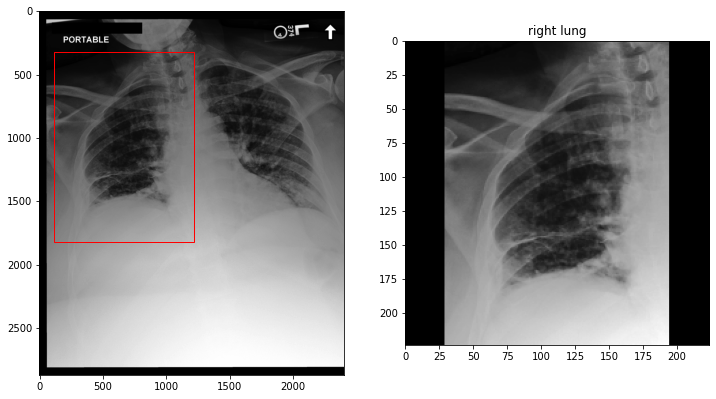

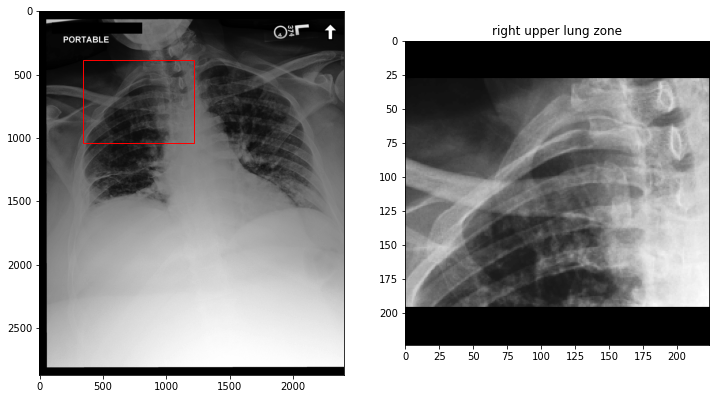

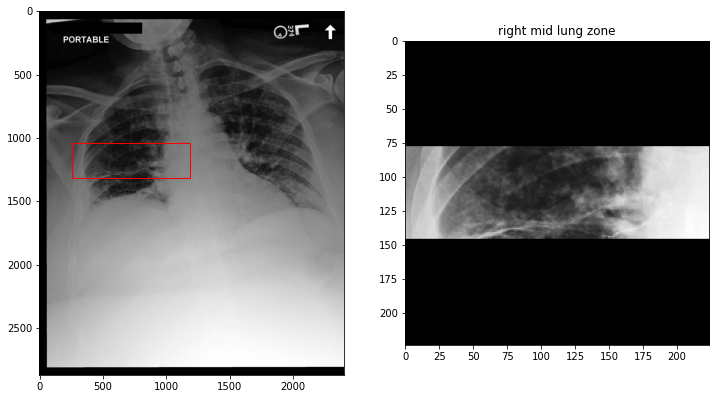

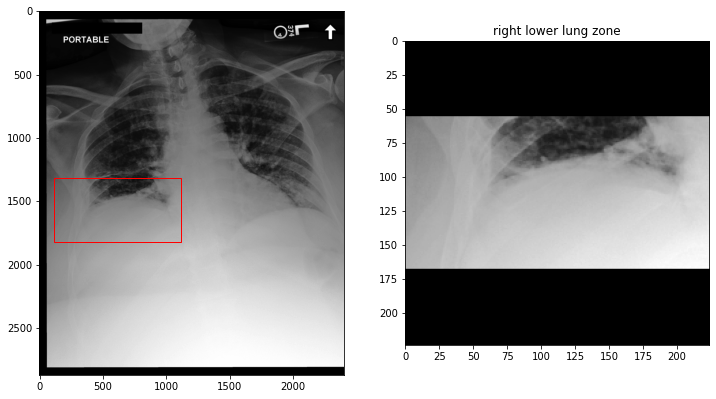

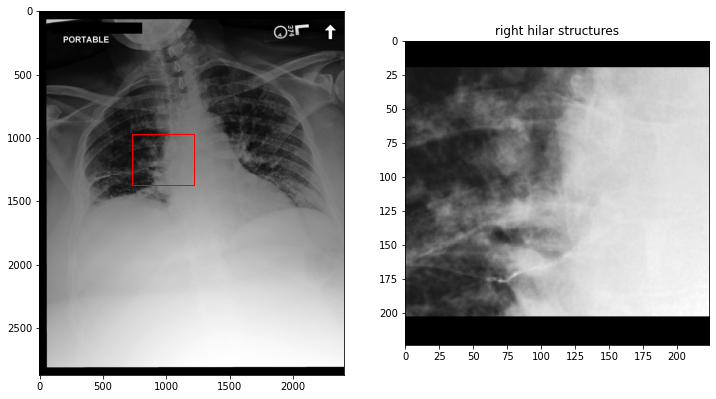

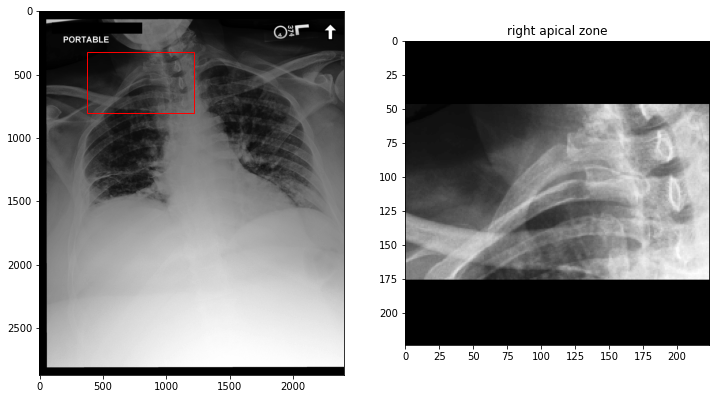

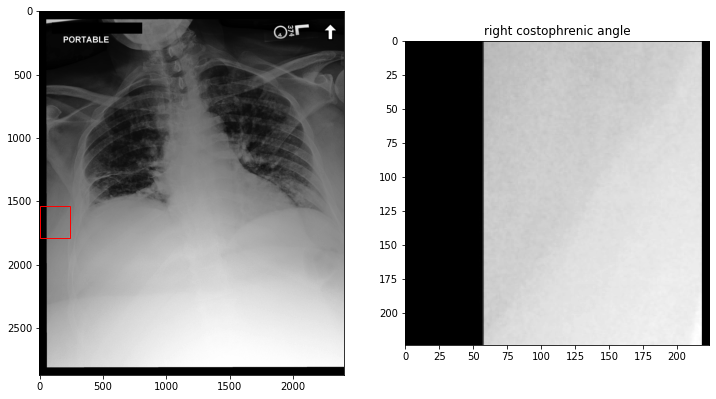

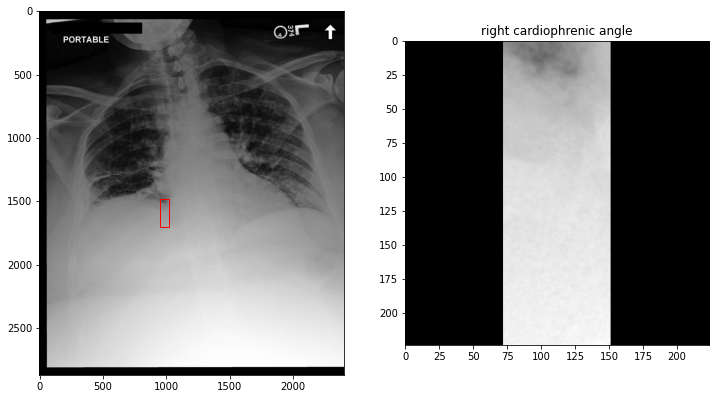

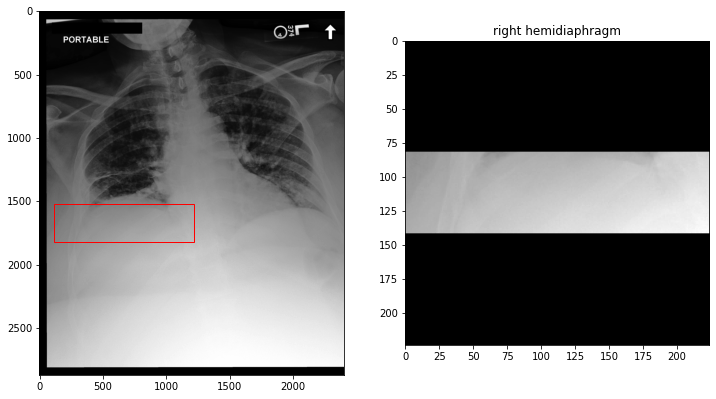

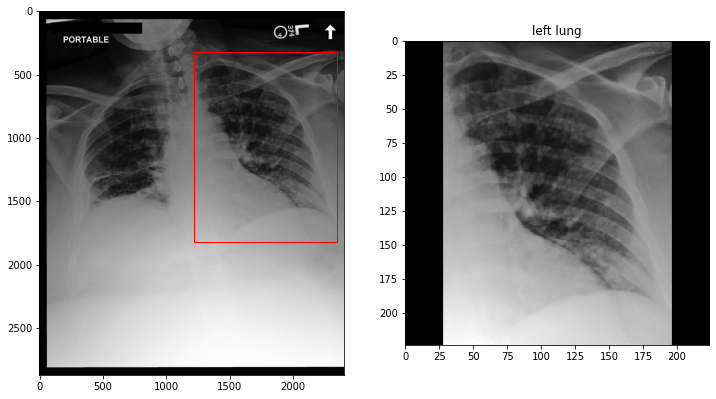

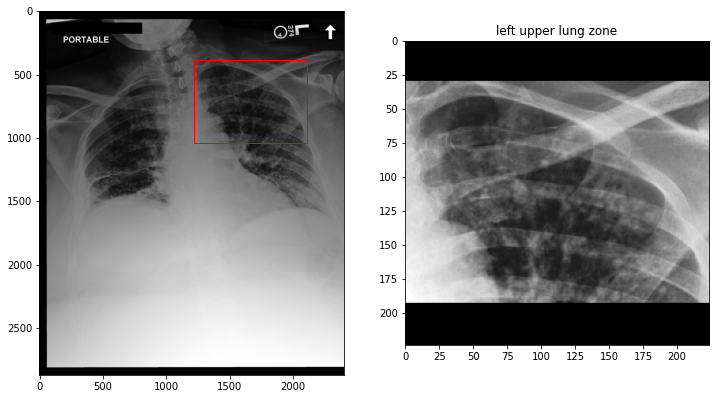

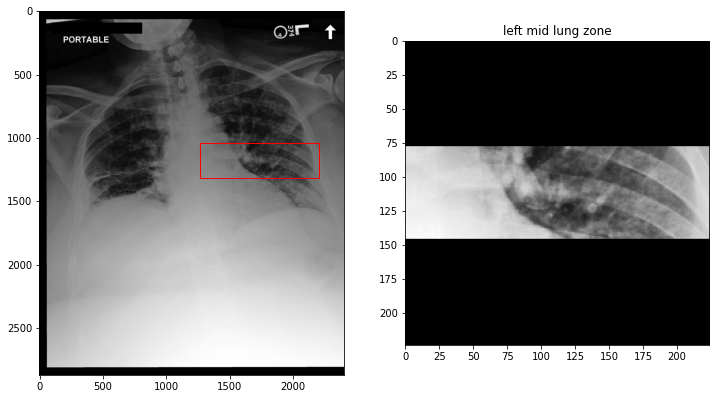

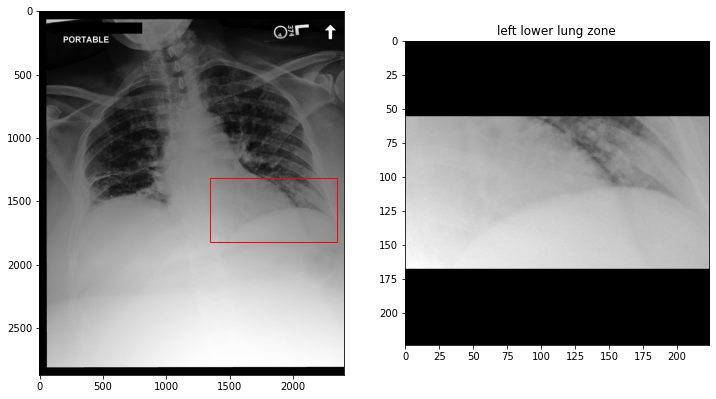

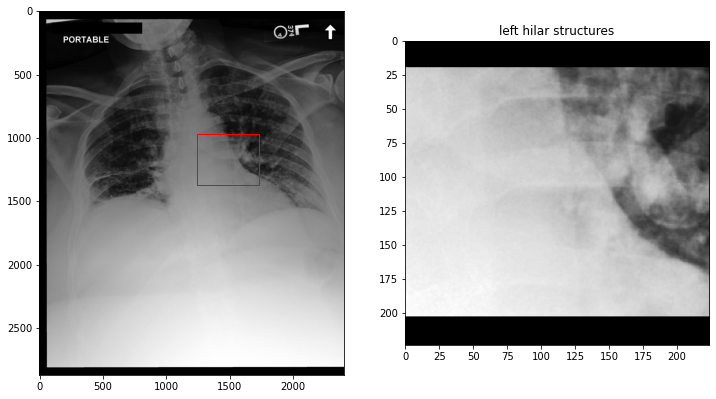

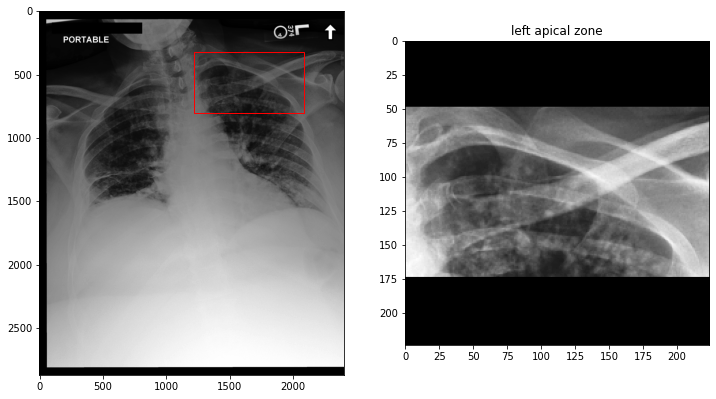

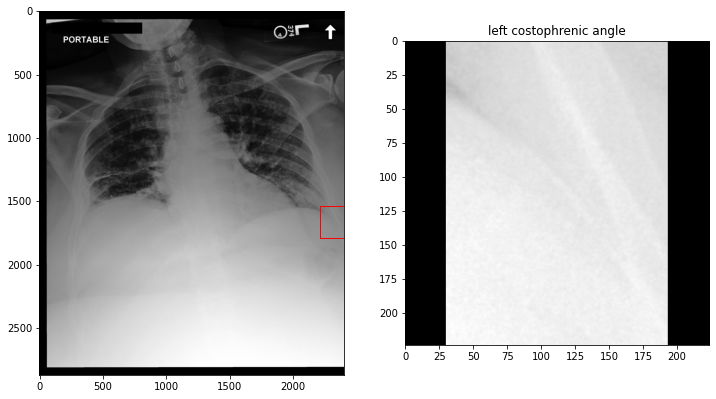

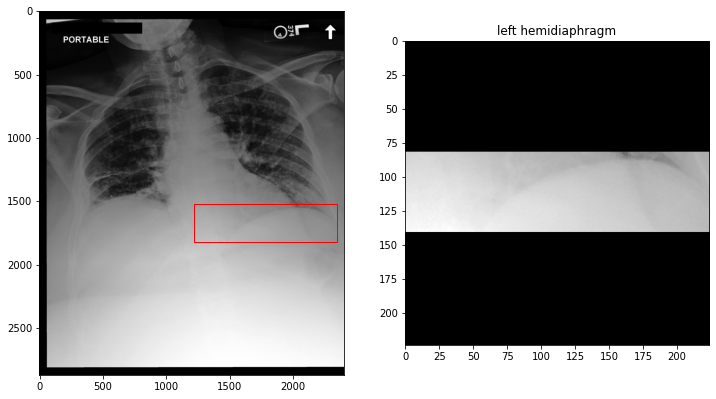

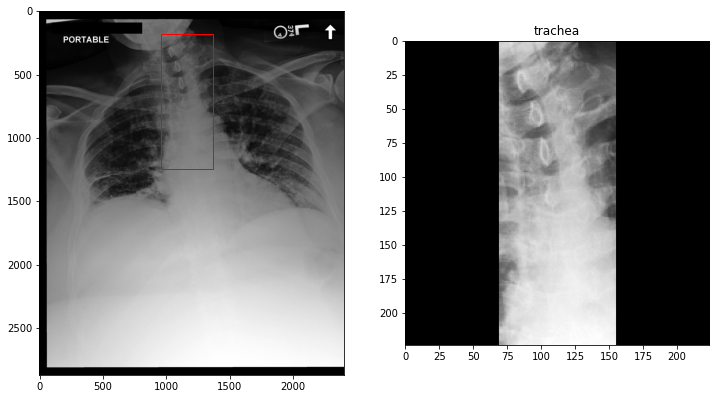

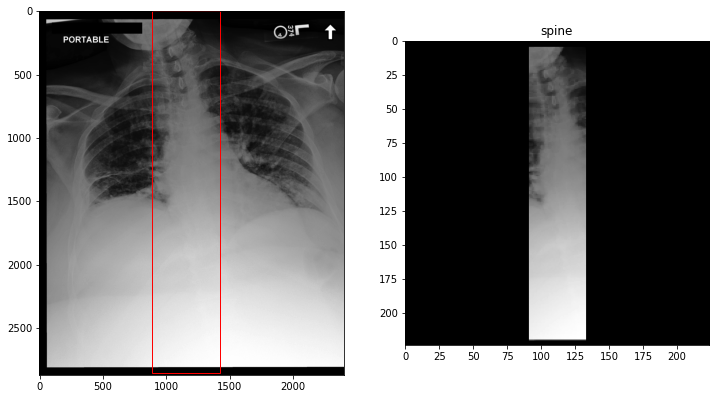

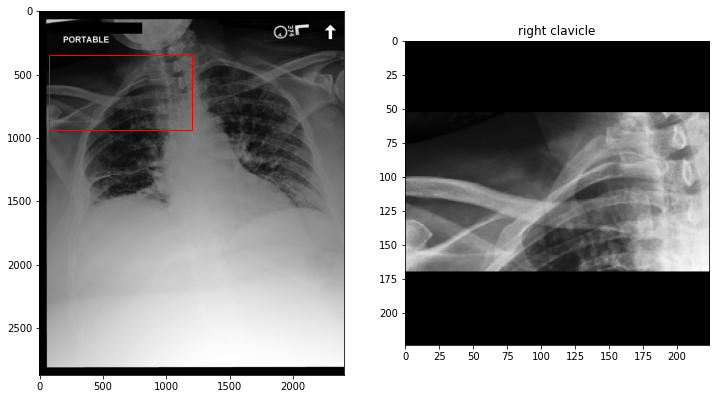

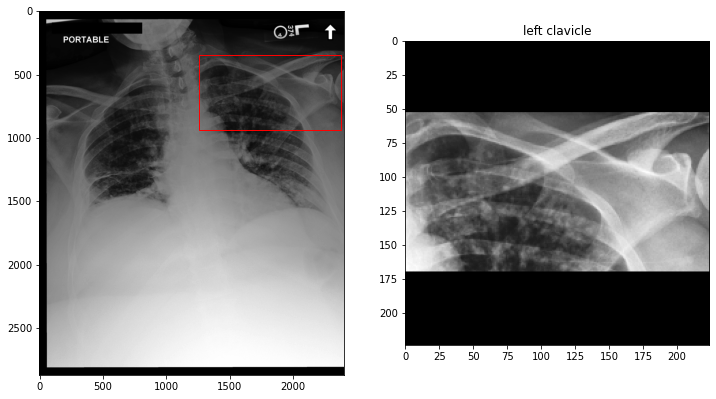

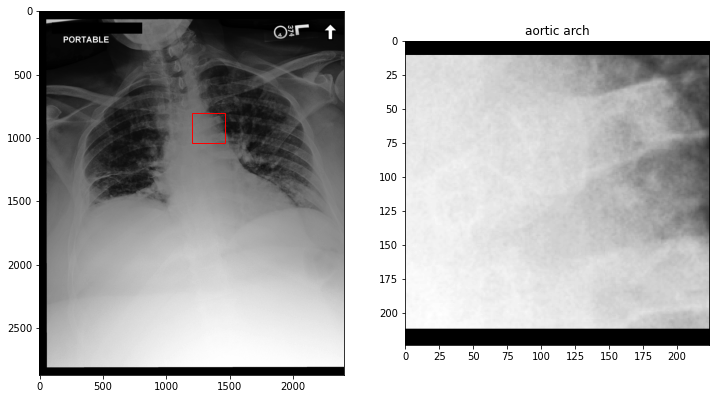

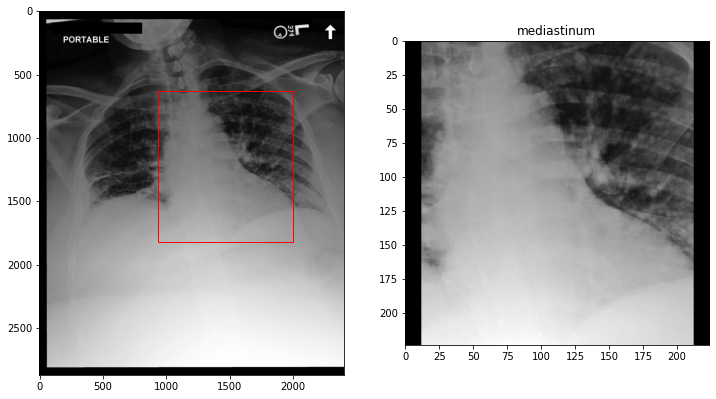

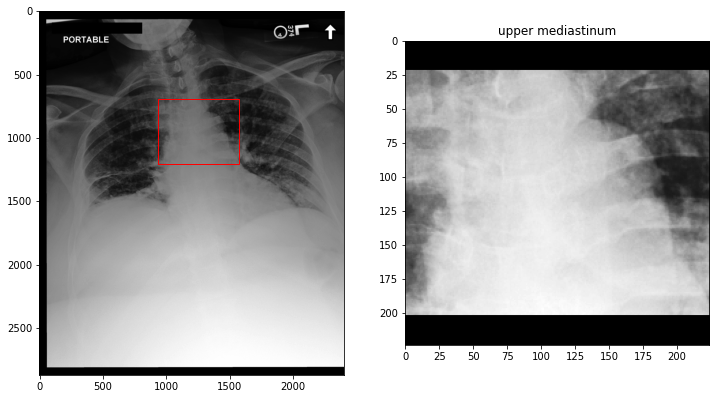

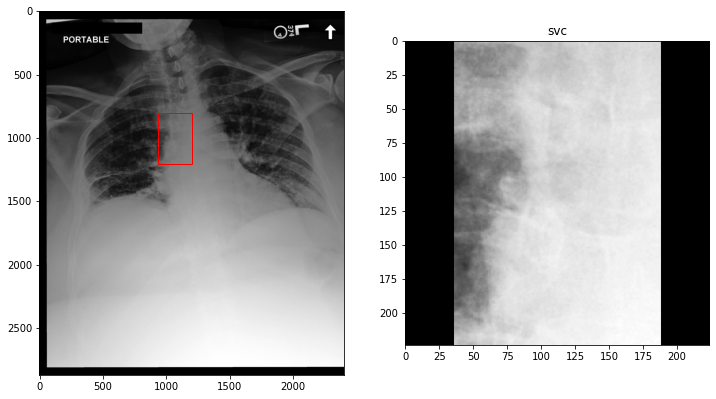

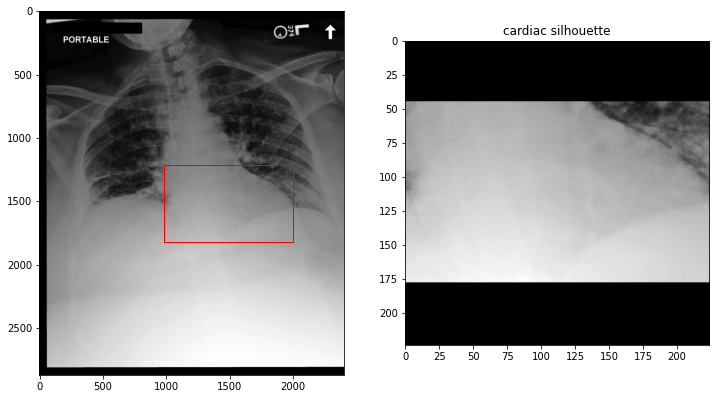

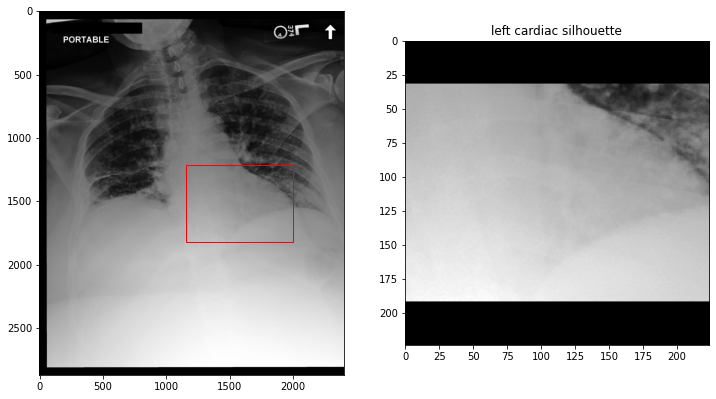

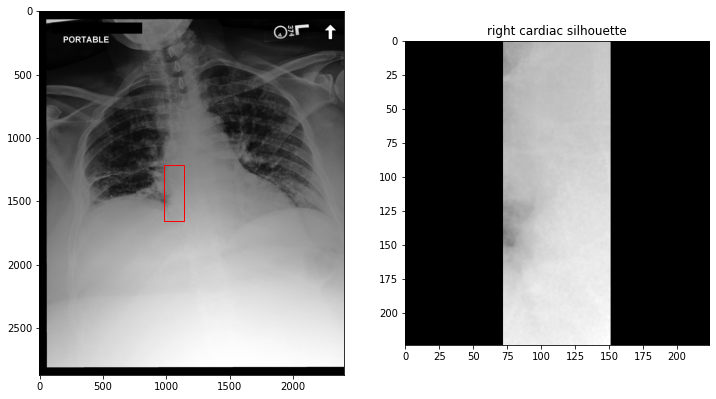

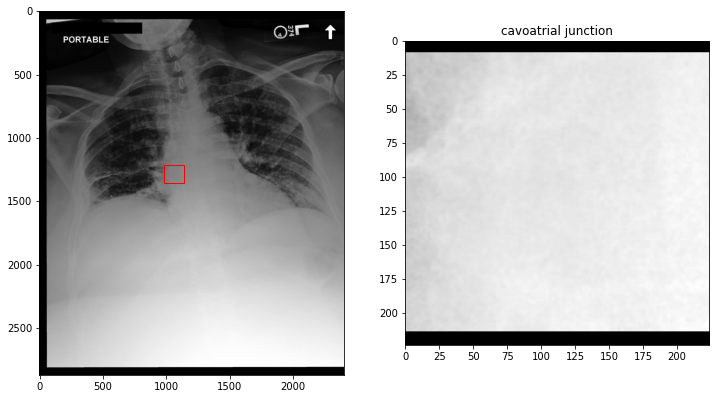

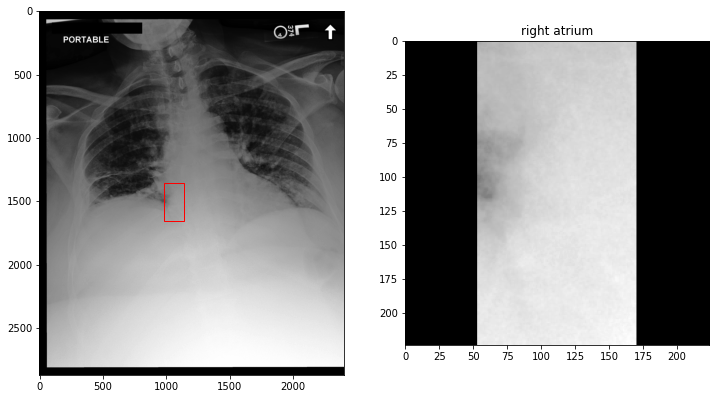

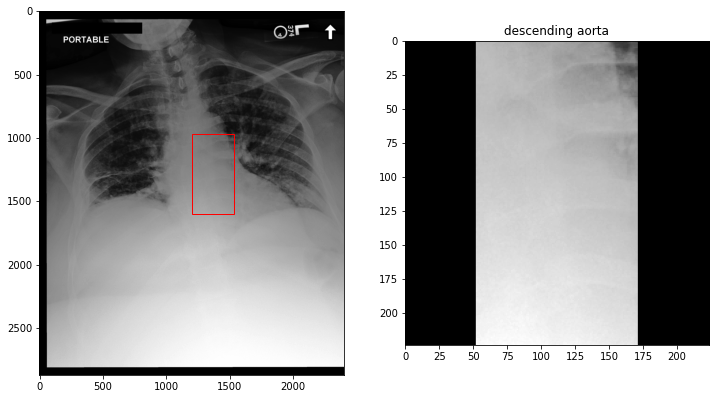

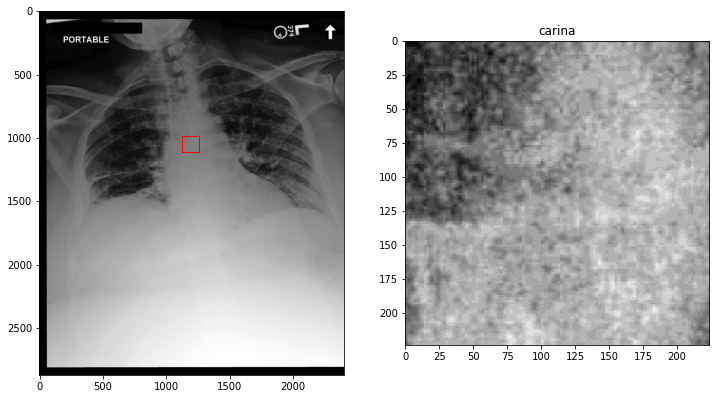

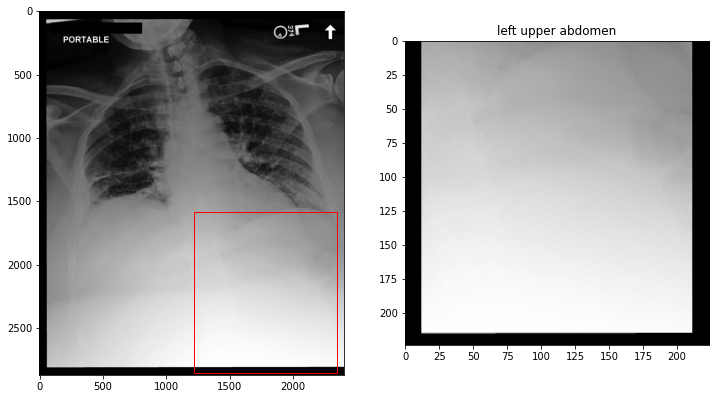

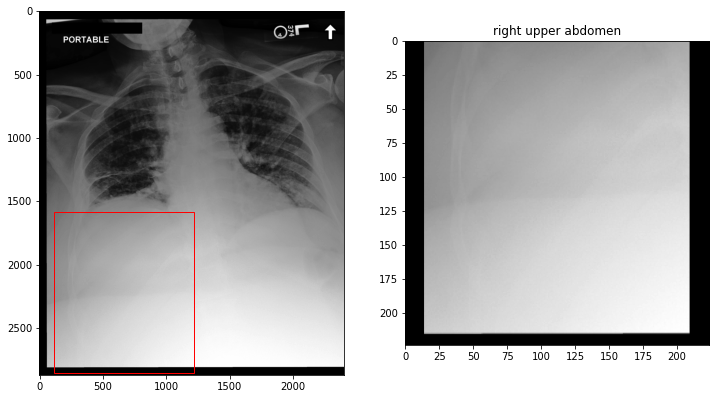

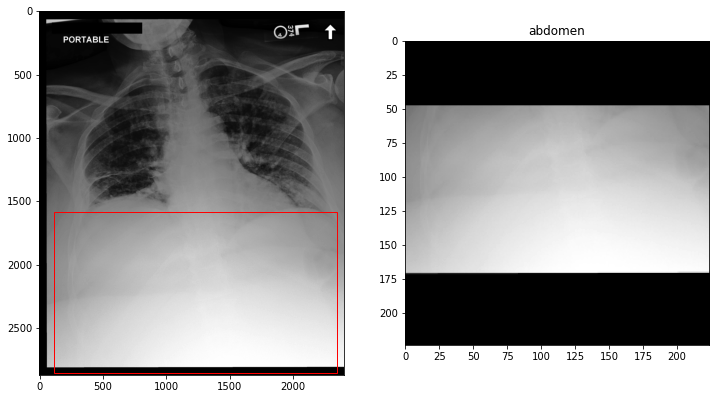

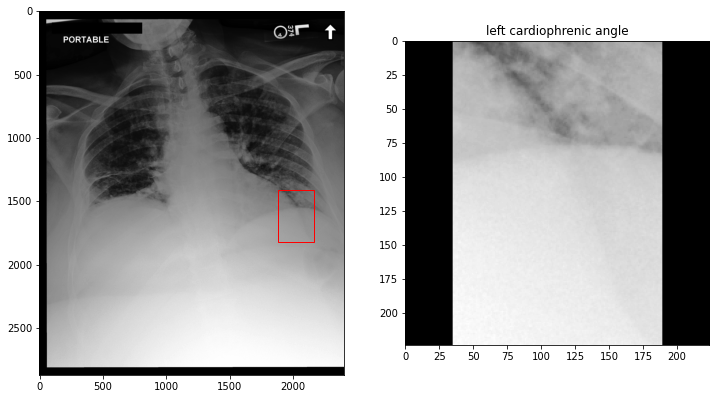

In [45]:
NUM_ANATOMICAL_REGIONS = 36

for i in range(NUM_ANATOMICAL_REGIONS):
    bbox_image_tensor = batch_images[i]
    bbox_name = datasets_as_dfs["valid"].iloc[i, 1]  # 2nd column is bbox_name
    bbox_coordinates = datasets_as_dfs["valid"].iloc[i, 2:6]  # 3rd column to 6th column are bbox_coordinates

    show_chest_image_and_bbox_image_side_by_side(bbox_image_tensor, bbox_name, bbox_coordinates)

# II. Training the Model

#### Specify where to save trained model weights

In [48]:
best_model_save_path = "/u/home/tanida/weights/classification_model"

#### Specify training function

In [ ]:
def train_model(model, train_dl, val_dl, optimizer, lr_scheduler, epochs, patience):
    """
    Train a model on train set and evaluate on validation set.
    Saves best model w.r.t. val loss.
    
    Parameters
    ----------
    model: nn.Module
        The input model to be trained.
    train_dl: torch.utils.data.Dataloder
        The train dataloader to train on.
    val_dl: torch.utils.data.Dataloder
        The val dataloader to validate on.
    optimizer: Optimizer
        The model's optimizer.
    lr_scheduler: torch.optim.lr_scheduler
        The learning rate scheduler to use.
    epochs: int
        Number of epochs to train for.
    patience: int
        Number of epochs to wait for val loss to decrease.
        If patience is exceeded, then training is stopped early.

    Returns
    -------
    None, but saves model with the lowest val loss over all epochs.
    """
    
    lowest_val_loss = np.inf
    
    # the best_model_state is the one where the val loss is the lowest over all epochs
    best_model_state = None
    num_epochs_without_decrease_val_loss = 0 # parameter to determine early stopping
    
    for epoch in range(epochs):
        # training the model on the train set
        model.train()
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0
        
        for images, targets in tqdm(train_dl):
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            logits = model(images)
            loss = binary_cross_entropy_with_logits(logits.squeeze().float(), targets.float())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item() * images.size(0)
            num_train_correct  += ((logits > 0).squeeze() == targets).sum().item()
            num_train_examples += images.size(0)
            
        train_loss = train_loss / len(train_dl)
        train_acc = num_train_correct / num_train_examples
        
        writer.add_scalar('training loss', train_loss, epoch)
        writer.add_scalar('training accuracy', train_acc, epoch)
            
        # evaluating the model on the val set
        model.eval()
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0
        
        # class metrics
        cls_correct = [0, 0] # defect has index 0, good has index 1
        cls_count = [0, 0]
        
        for images, targets in val_dl:
            images = images.to(device)
            targets = targets.to(device)
            logits = model(images)
            preds = (logits > 0).squeeze()
            loss = binary_cross_entropy_with_logits(logits.squeeze().float(), targets.float())

            val_loss += loss.item() * images.size(0)
            num_val_correct  += (preds == targets).sum().item()
            num_val_examples += images.size(0)
            
            # class metrics
            for i in range(len(targets)):
                cls_index = targets[i]
                cls_correct[cls_index] += 1 if int(preds[i]) == cls_index else 0
                cls_count[cls_index] += 1
            
        val_loss = val_loss / len(val_dl)
        val_acc = num_val_correct / num_val_examples
        val_acc_defect = cls_correct[0] / cls_count[0] # defect has index 0
        val_acc_good = cls_correct[1] / cls_count[1] # defect has index 1
        
        writer.add_scalar('validation loss', val_loss, epoch)
        writer.add_scalar('validation accuracy', val_acc, epoch)
        writer.add_scalar('validation accuracy: defect', val_acc_defect, epoch)
        writer.add_scalar('validation accuracy: good', val_acc_good, epoch)
        
        # lr_scheduler decreases lr by 1e-1 if val_loss has not reduced after patience_lr_scheduler epochs
        lr_scheduler.step(val_loss)
        
        print(f"Epoch: {epoch}:\n\tTrain loss: {train_loss:.3f}\n\tTrain acc: {train_acc:.3f}\n\tVal loss: {val_loss:.3f}\n\tVal acc: {val_acc:.6f}")
        print(f"\tVal acc 'defect': {val_acc_defect:.6f}")
        print(f"\tVal acc 'good': {val_acc_good:.6f}")
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_model_save_path = os.path.join(model_save_path, f"layers_retrained_{num_layers_to_retrain}_val_acc_good_{val_acc_good:.5f}_val_acc_defect_{val_acc_defect:.5f}_epoch_{epoch}.pth")
            best_model_state = deepcopy(model.state_dict())
            num_epochs_without_decrease_val_loss = 0
        else:
            num_epochs_without_decrease_val_loss += 1
            
        if num_epochs_without_decrease_val_loss >= patience:
            print(f"\nEarly stopping at epoch ({epoch}/{epochs})!")
            print(f"Lowest overall val loss: {lowest_val_loss}")
            return None
             
        # also save models that achieve high val accuracy for the defect class
        # if val_acc_defect > 0.985:
        #    save_path = os.path.join(model_save_path, f"layers_retrained_{num_layers_to_retrain}_val_acc_good_{val_acc_good:.5f}_val_acc_defect_{val_acc_defect:.5f}_epoch_{epoch}.pth")
        #    torch.save(model.state_dict(), save_path)
        
    # save the model with the overall lowest val loss
    torch.save(best_model_state, best_model_save_path)
    print(f"\nFinished training!")
    print(f"Lowest overall val loss: {lowest_val_loss}")
    return None        

In [40]:
try:
    for i in range(727, len(train_dataset)):
        train_dataset[i]
except:
    print(i)

1590


In [14]:
from time import time
import multiprocessing as mp
for num_workers in range(2, mp.cpu_count(), 2):  
    train_loader = DataLoader(train_dataset,shuffle=True,num_workers=num_workers,batch_size=64,pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for data in train_loader:
            continue
    end = time()
    print(f"Finish with:{end - start} second, num_workers={num_workers}")

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/u/home/tanida/region-guided-chest-x-ray-report-generation/src/encoder/custom_image_dataset.py", line 34, in __getitem__
    cropped_image = self.transforms(image=cropped_image)["image"]
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/composition.py", line 210, in __call__
    data = t(force_apply=force_apply, **data)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 97, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/core/transforms_interface.py", line 112, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/resize.py", line 83, in apply
    return F.longest_max_size(img, max_size=max_size, interpolation=interpolation)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 70, in wrapped_function
    result = func(img, *args, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 324, in longest_max_size
    return _func_max_size(img, max_size, interpolation, max)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 318, in _func_max_size
    img = resize(img, height=new_height, width=new_width, interpolation=interpolation)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 70, in wrapped_function
    result = func(img, *args, **kwargs)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/geometric/functional.py", line 277, in resize
    return resize_fn(img)
  File "/u/home/tanida/.conda/envs/cxr_env/lib/python3.10/site-packages/albumentations/augmentations/functional.py", line 189, in __process_fn
    img = process_fn(img, **kwargs)
cv2.error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



[ WARN:0@107.334] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p11/p11996157/s54968421/31c32ffd-aac9a015-868cb1e2-86f5a335-ac3d672f.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.570] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/u/home/tanida/datasets/mimic-cxr-jpg/files/p11/p11914297/s54901424/d0539208-cc42e490-6a63a524-cfa102bd-675a07c2.jpg'): can't open/read file: check file path/integrity


In [ ]:
train_transforms = A.Compose([
    # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted), 
    # while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)

    # the custom class CustomResize resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio
    A.LongestMaxSize(max_size=224, interpolation=cv2.INTER_AREA),
    A.PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT)
])

In [40]:
from PIL import Image
import cv2
import imagesize
from IPython import display

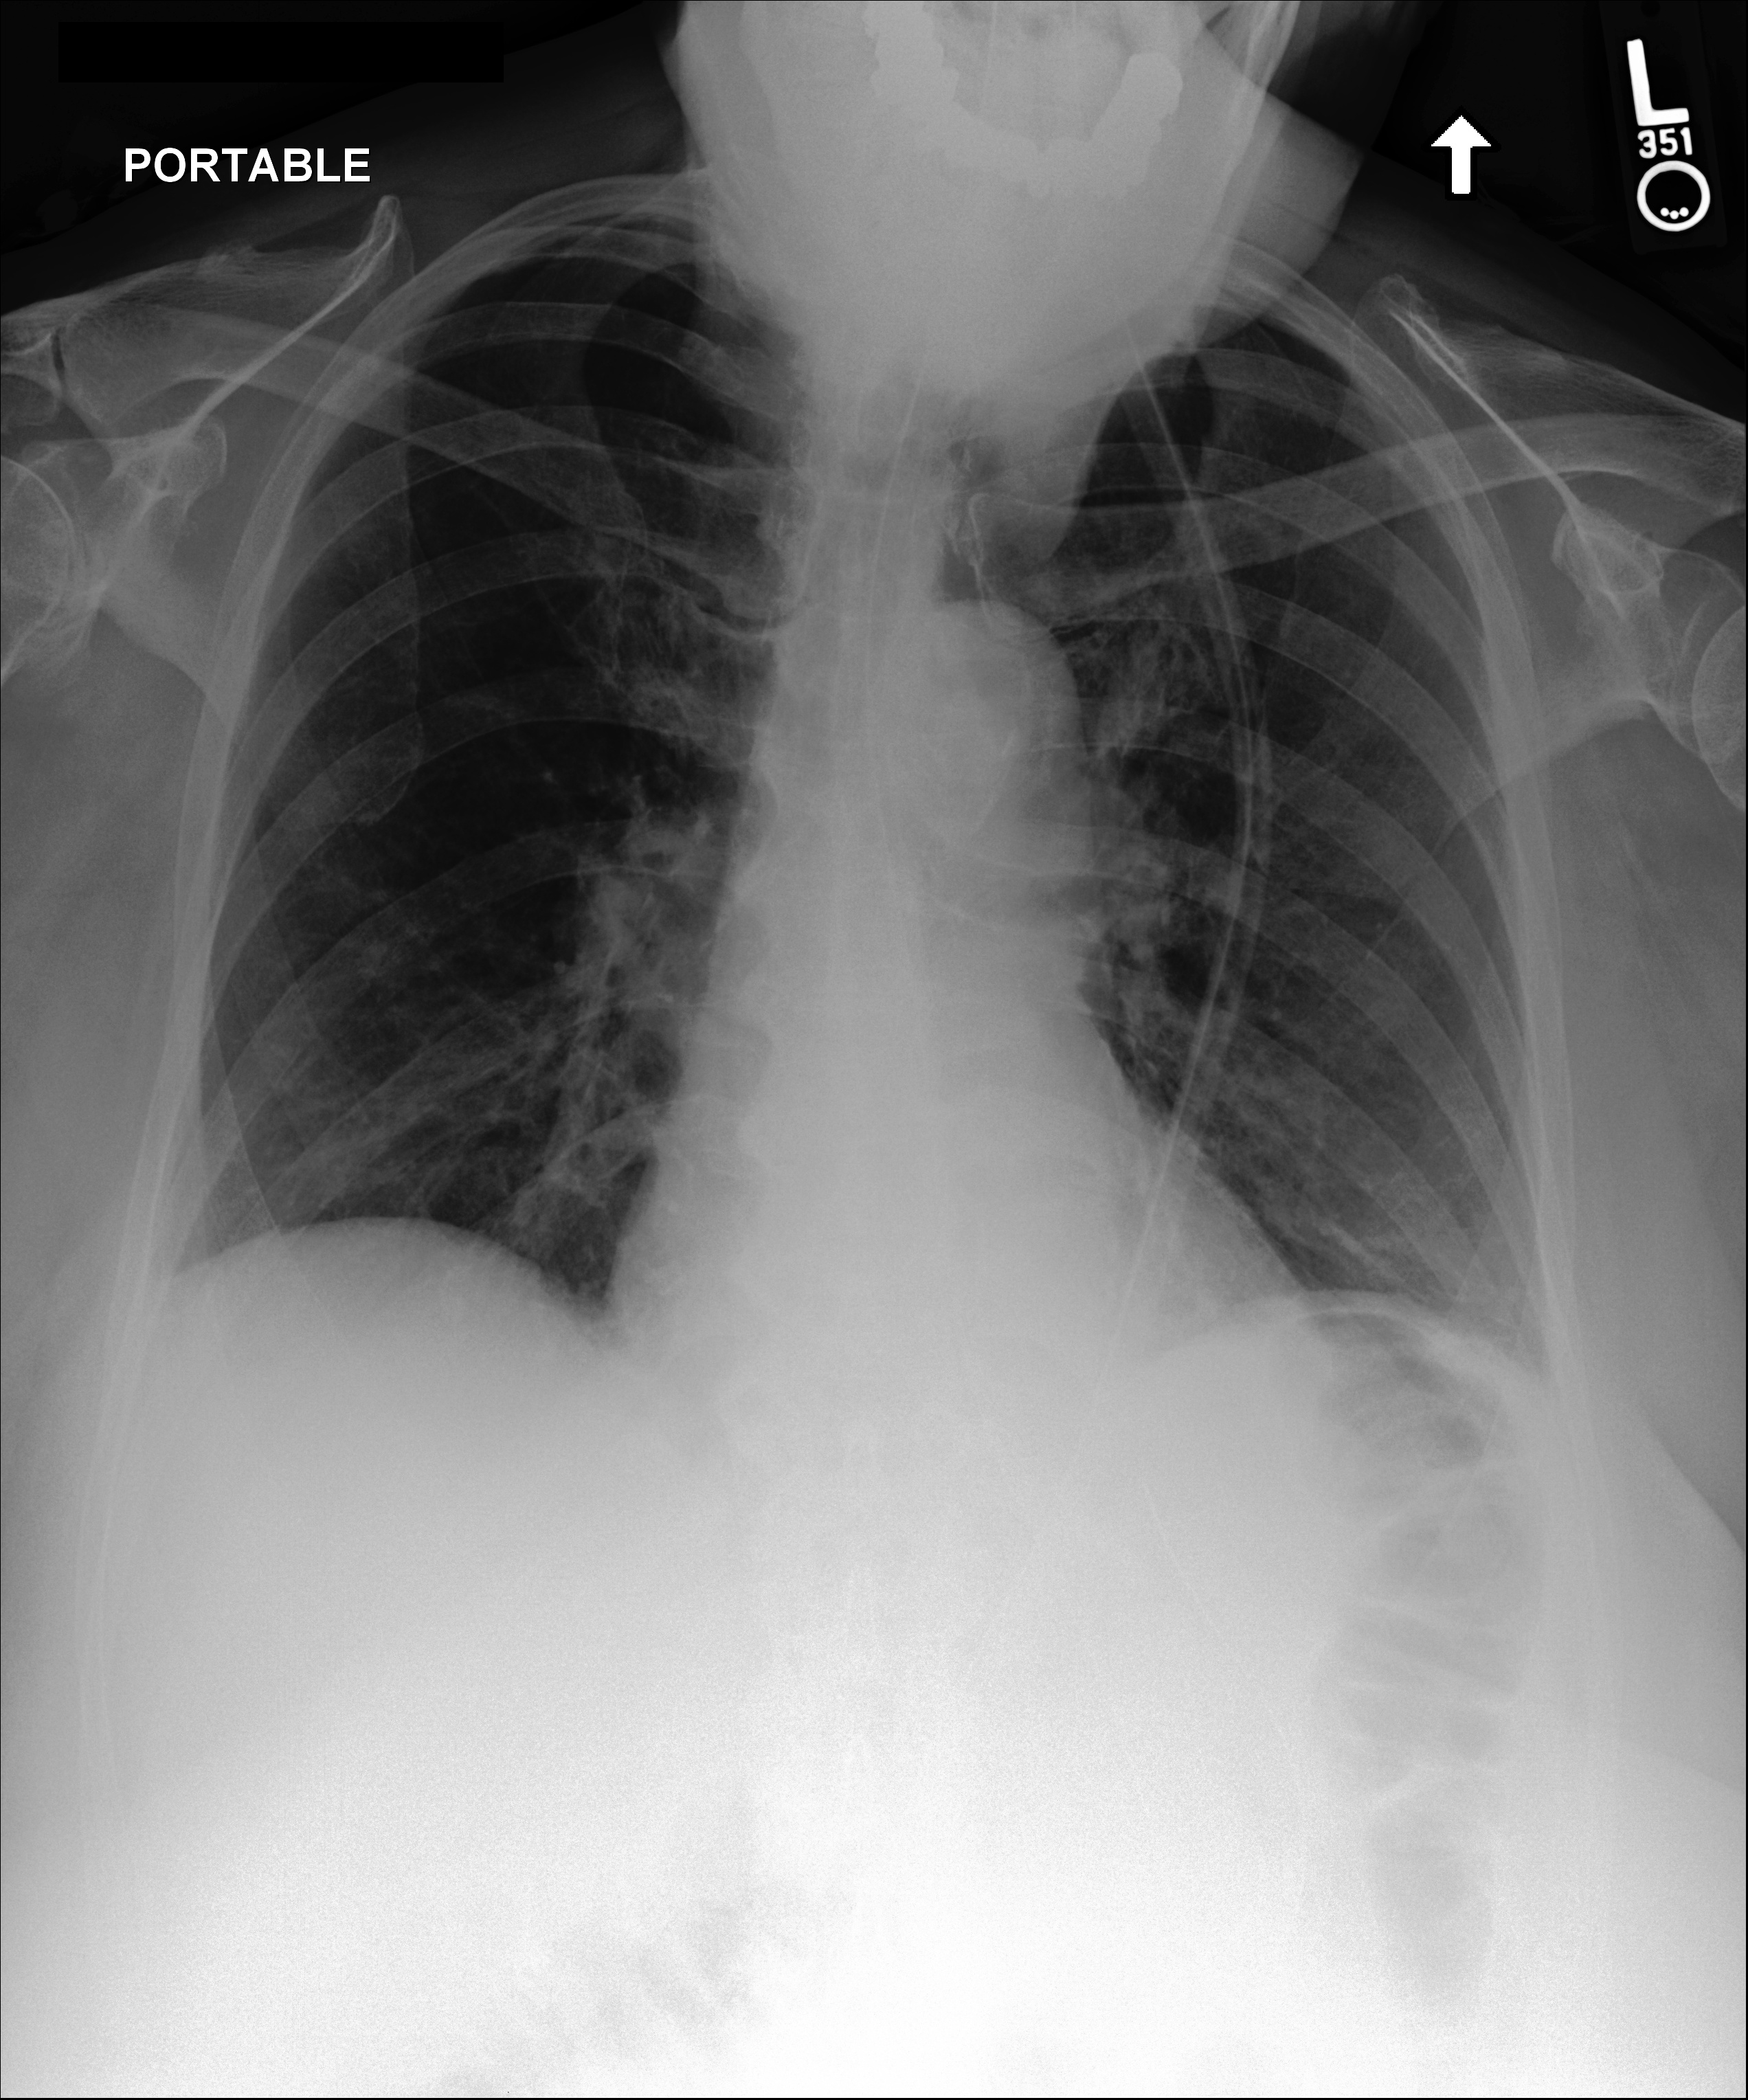

In [42]:
display.Image(image_path, width=500, height=500)

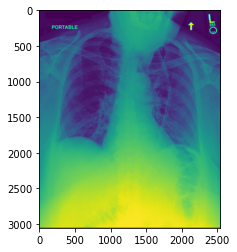

In [37]:
image_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
# image = Image.open(image_path)
# image.size

image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
image.shape

# imagesize.get(image_path)
plt.imshow(image)


<class 'PIL.Image.Image'>
(2019, 1242)


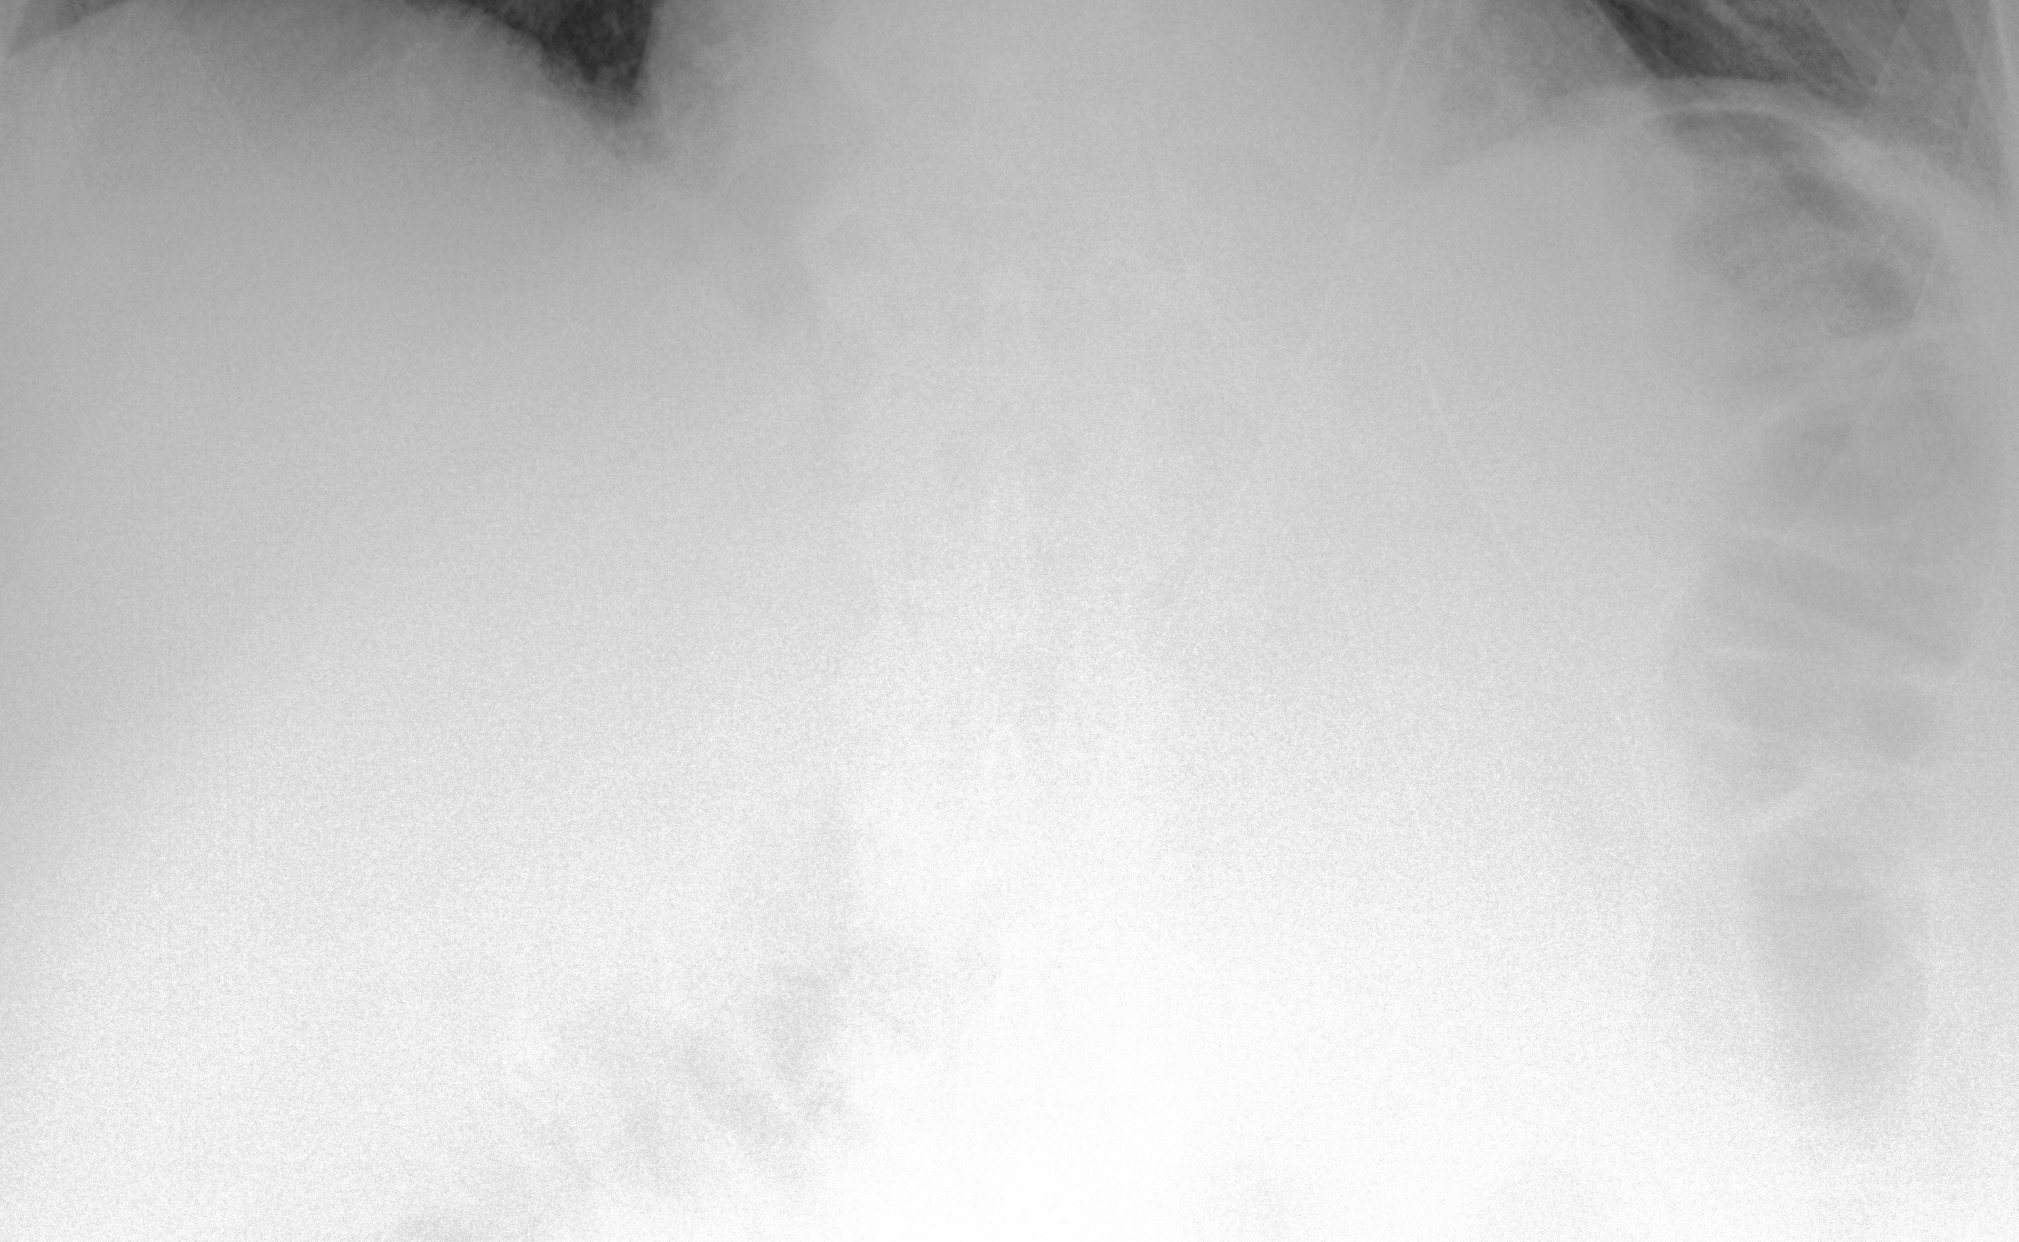

In [29]:
image_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
image = Image.open(image_path)

bbox_coords = [245, 1800, 2264, 3042]
cropped_image = image.crop(box=bbox_coords)

print(type(cropped_image))
print(cropped_image.size)
display(cropped_image)

In [67]:
0.301 * 255

76.755

In [ ]:
new_resized_cropped_image = train_transforms(image=np_cropped_image)["image"]
print(new_resized_cropped_image.shape)
plt.imshow(new_resized_cropped_image)

In [ ]:
new_resized_cropped_image == resized_cropped_image

In [ ]:
resized_cropped_image = transforms.functional.resize(cropped_image, size=223, max_size=224)
print(resized_cropped_image)
display(resized_cropped_image)

In [14]:
from torchvision.transforms.functional import pil_to_tensor

In [63]:
img_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p13/p13820640/s54192530/e9b7f879-0aa0b42d-5b1b752d-69ae71ac-3d0da7af.jpg"
cv2_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
mean = cv2_img.mean()
print(mean)
last_mean_values = [3.5, 123.3, 234.3]
print(abs(mean - last_mean_values) <= 1000)
print(np.all([abs(mean - last_mean_values) <= 1000, abs(mean - last_mean_values) <= 10]))


128.9662323987866
[ True  True  True]
False


In [69]:
import multiprocessing as mp
mp.cpu_count()

48

In [ ]:
# specify path to folder where model weights should be saved
model_save_path = "/u/home/tanida/weights/encoder"